In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
path = Path('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles')
path.ls()

[PosixPath('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/sample_submission.csv'),
 PosixPath('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train.csv'),
 PosixPath('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test.csv'),
 PosixPath('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test'),
 PosixPath('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train')]

In [5]:
path_anno = path/'train'
fn_paths = get_image_files(path_anno)

In [6]:
len(fn_paths)

1646

In [7]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

image_names  emergency_or_not
0    1503.jpg                 0
1    1420.jpg                 0
2    1764.jpg                 0
3    1356.jpg                 0
4    1117.jpg                 0

In [8]:
def get_labels(file_path):
        for row in train_df.itertuples():
            if '/'+row.image_names in str(file_path):           
                return row.emergency_or_not

In [9]:
labels = list(map(get_labels, fn_paths))

In [10]:
len(labels)

1646

In [11]:
tfms = get_transforms()
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=224, bs=bs, valid_pct=0.25).normalize(imagenet_stats)

In [12]:
data.show_batch(rows=20, figsize=(20,20))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([0, 1], 2, 1235, 411)

In [14]:
!mkdir -p /root/.cache/torch/checkpoints/
!cp /kaggle/input/resnet152/resnet152.pth /root/.cache/torch/checkpoints/resnet152.pth

In [15]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, model_dir=Path('/kaggle/input/resnet152'))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [17]:
learn.fit_one_cycle(10)

In [18]:
learn.model_dir = '/kaggle/output/resnet152/'

In [19]:
learn.save('/kaggle/output/resnet152/stage-1-152')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [21]:
interp.plot_top_losses(20, figsize=(20,20))

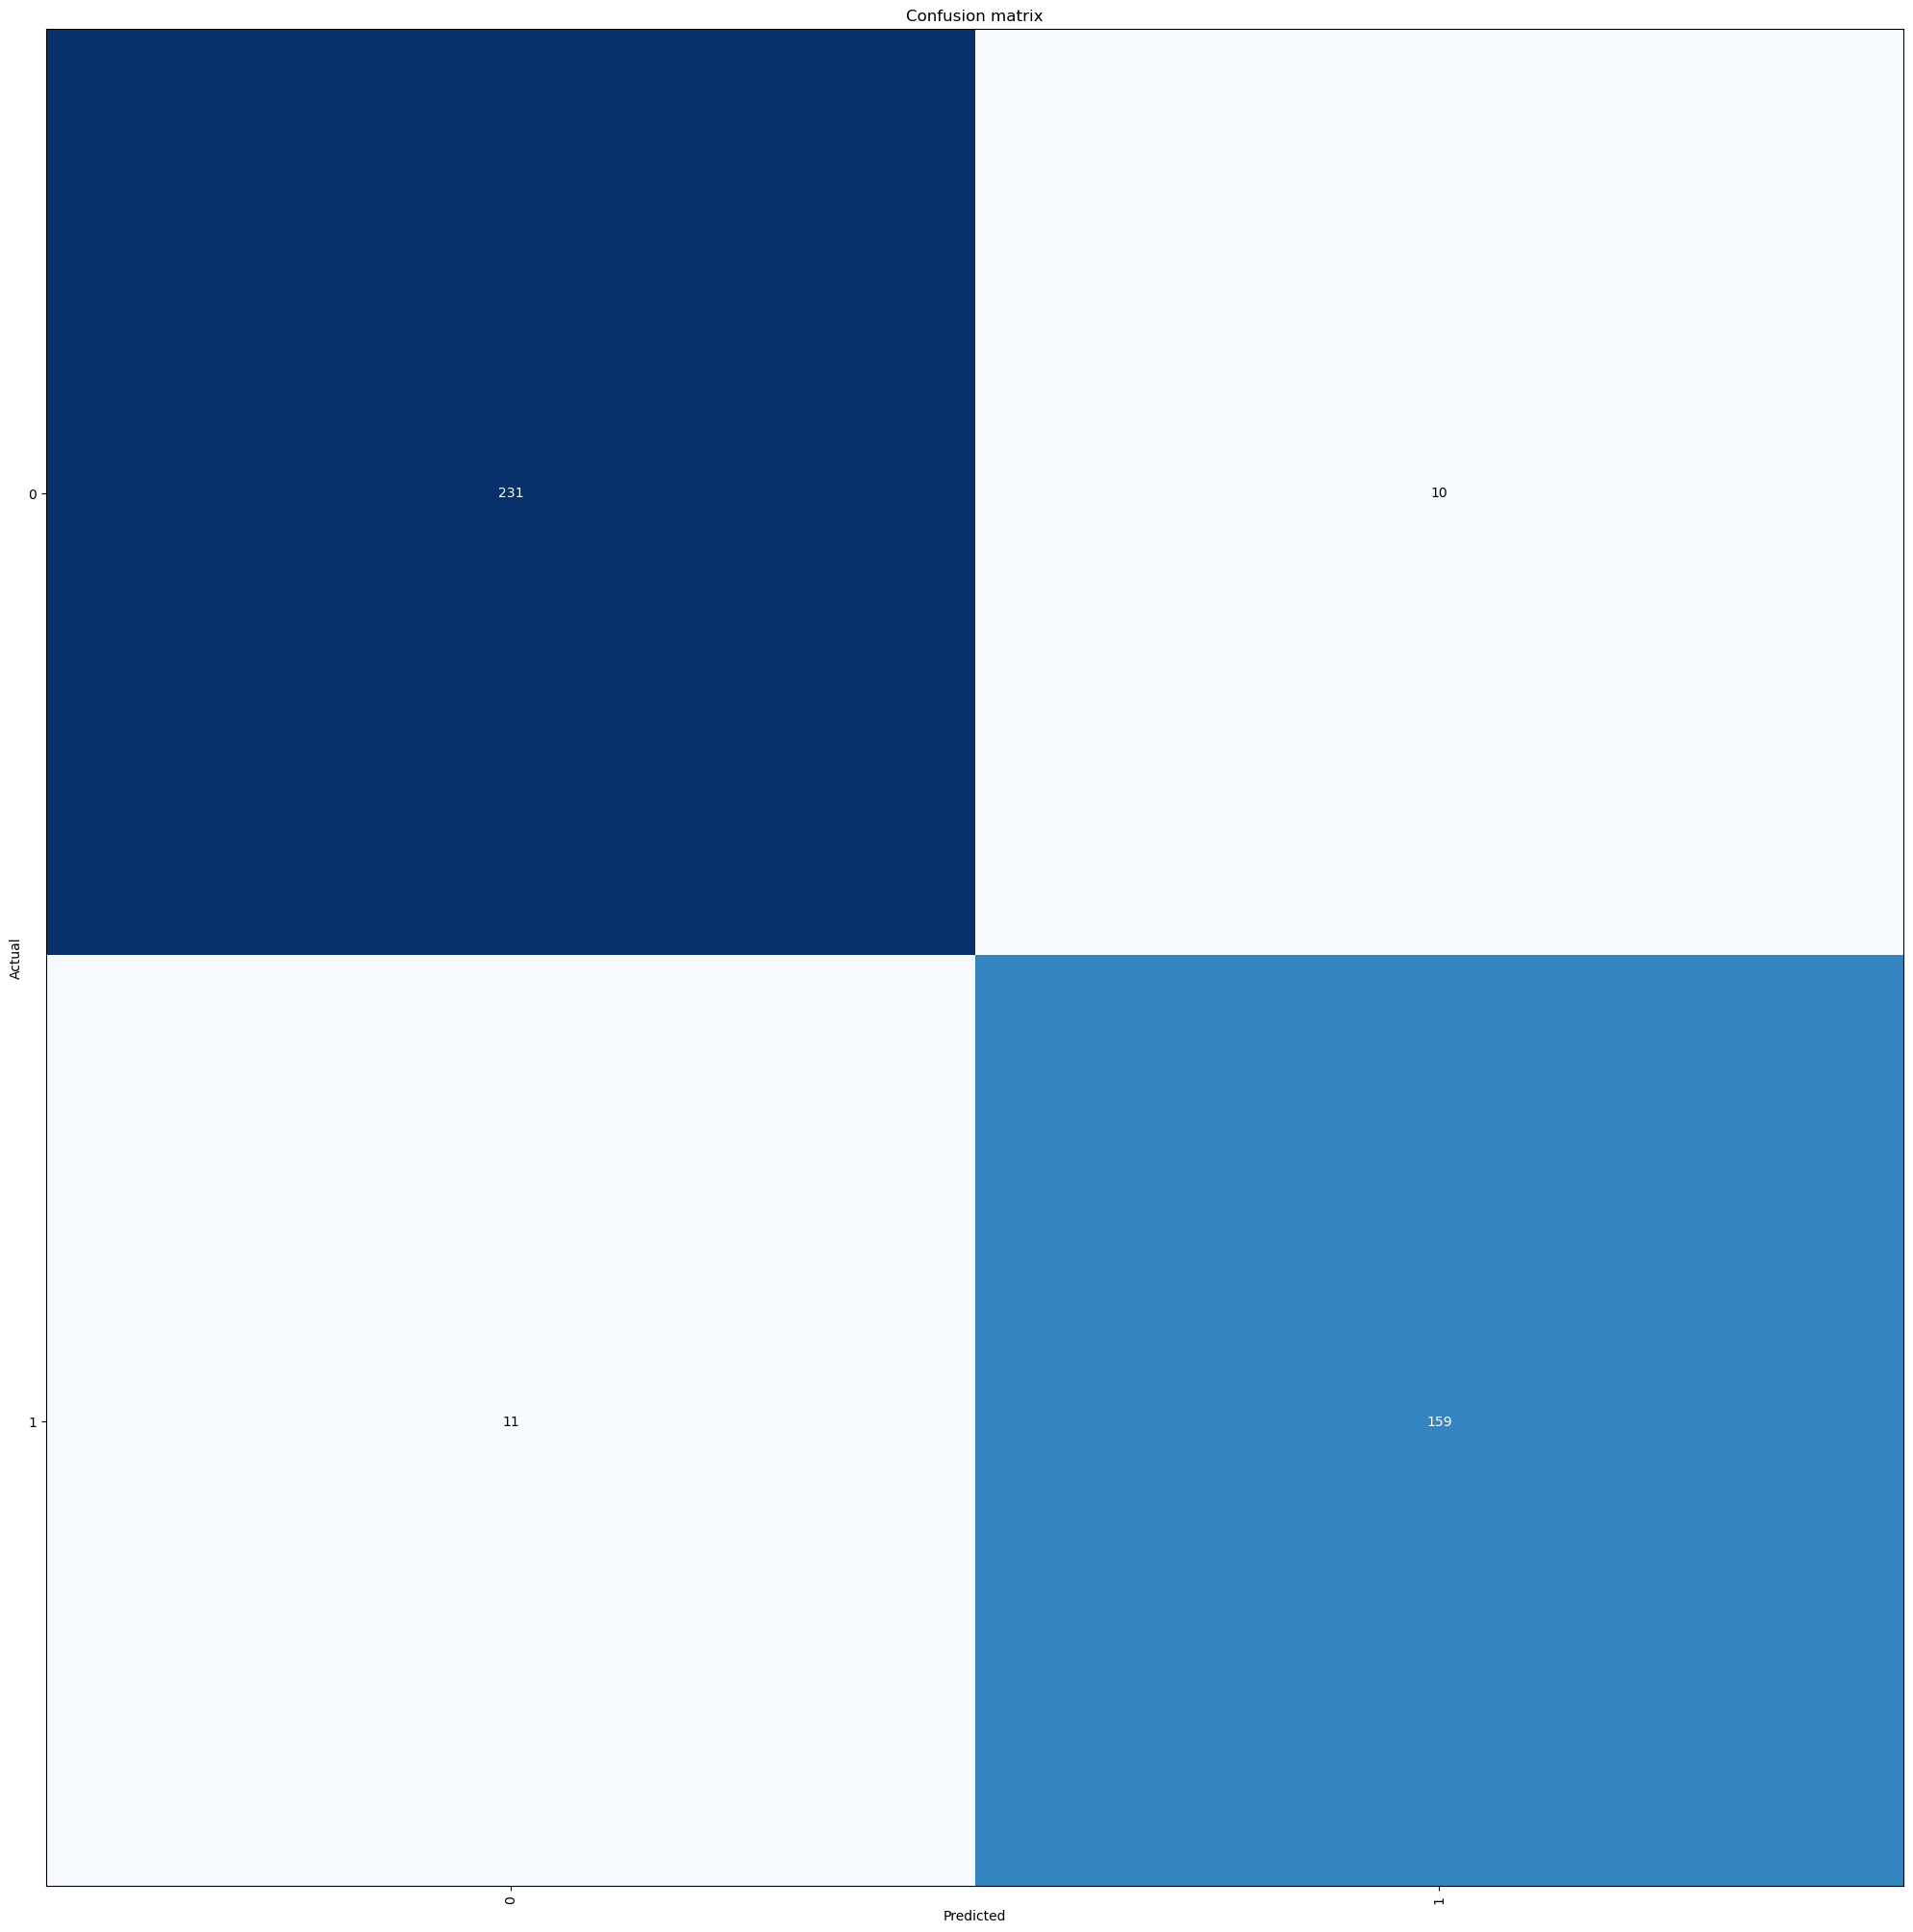

In [22]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=100)

In [23]:
interp.most_confused(min_val=2)

[(1, 0, 11), (0, 1, 10)]

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(4)

In [26]:
learn.load('/kaggle/output/resnet152/stage-1-152');

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [28]:
learn.recorder.plot()

In [29]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [31]:
interp.plot_top_losses(50, figsize=(20,20))

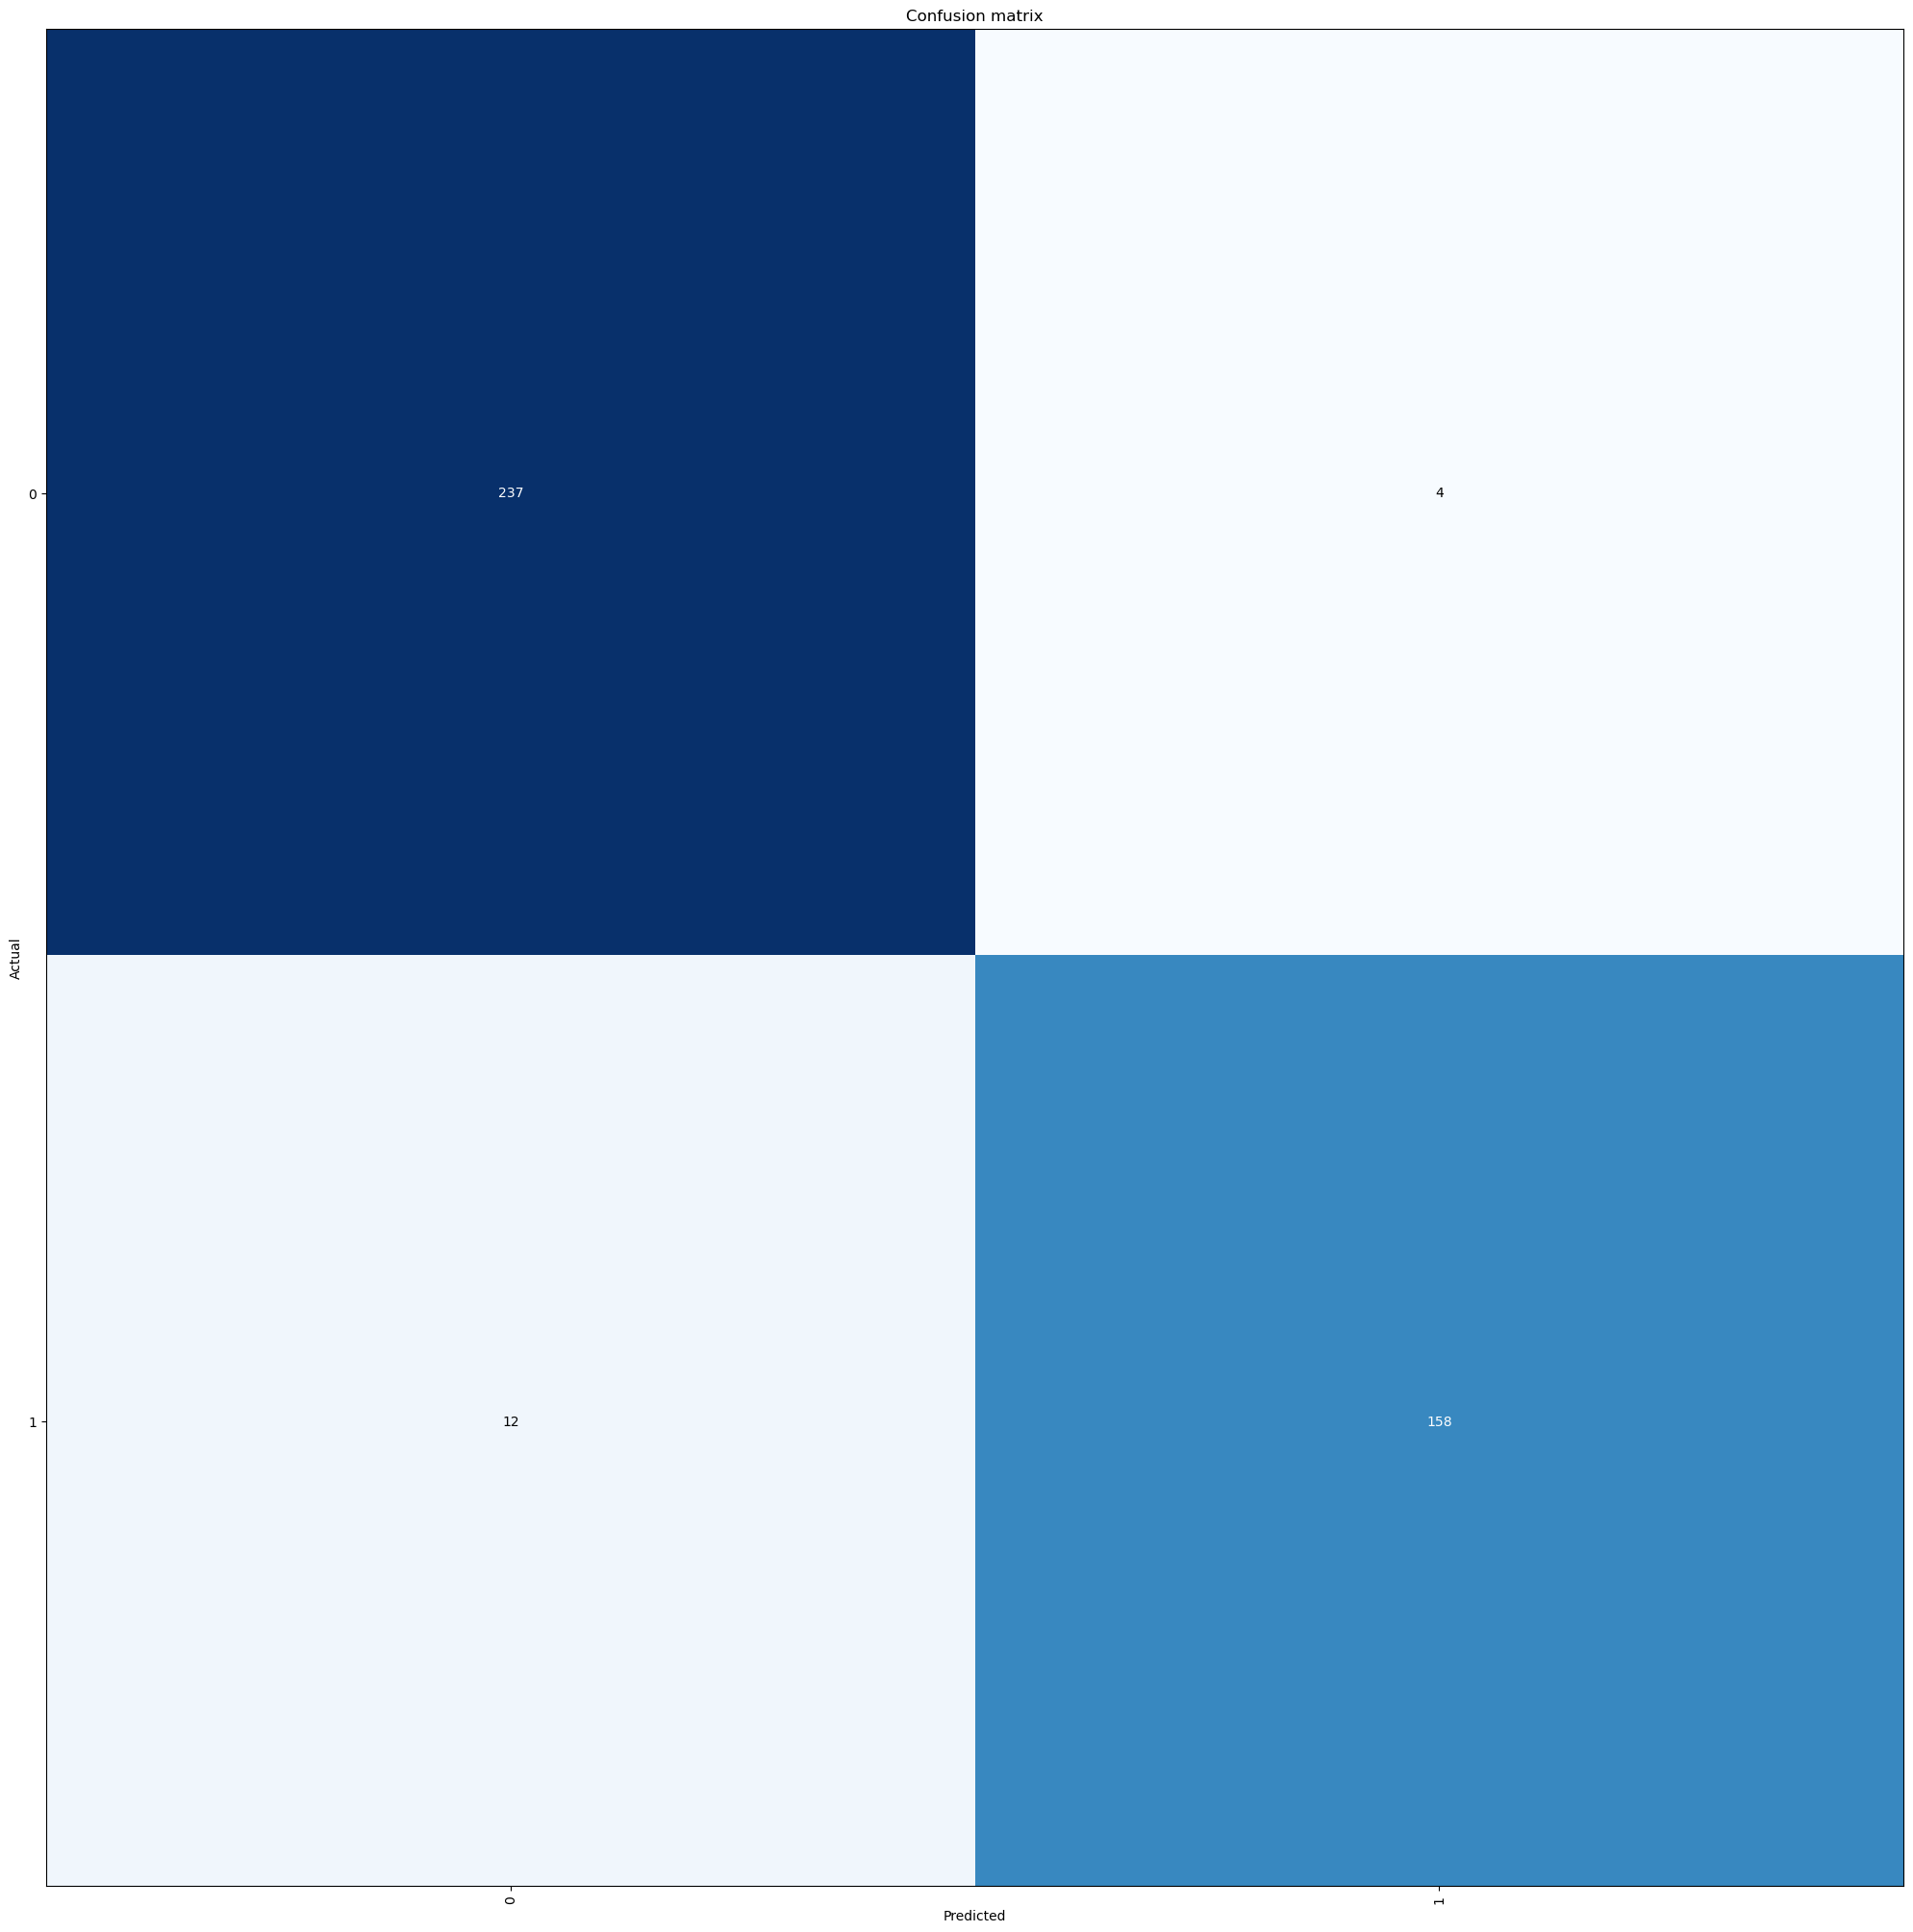

In [32]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=100)

In [33]:
interp.most_confused(min_val=1)

[(1, 0, 12), (0, 1, 4)]

In [34]:
learn.save('/kaggle/output/resnet152/stage-2-152')

In [35]:
path = learn.path

In [36]:
learn.export('/kaggle/output/resnet152/emergency_vehicles.pkl')

In [37]:
defaults.device = torch.device('cpu')

In [38]:
lego_learn = load_learner('/kaggle/output/resnet152', 'emergency_vehicles.pkl')

In [39]:
pred_path = path/'test'
pred_fn_paths = get_image_files(pred_path)

In [40]:
for pred_fn_path in pred_fn_paths:
    img = open_image(pred_fn_path)
    pred_class,pred_idx,outputs = learn.predict(img)
    print(pred_fn_path, pred_class)

/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1269.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/2008.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/208.jpg 1
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1789.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1411.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1501.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/2021.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1385.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/2278.jpg 0
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/56.jpg 1
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/20.jpg 1
/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/275.jpg 1
/kaggle/in

In [41]:
img = open_image('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/841.jpg')
img

In [42]:
pred_class,pred_idx,outputs = lego_learn.predict(img)
print(str(pred_class))

1


In [43]:
img = open_image('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/1287.jpg')
img

In [44]:
pred_class,pred_idx,outputs = lego_learn.predict(img)
print(str(pred_class))

0
